In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import time
from qiskit.providers.aer import QasmSimulator
import numpy as np
from qiskit_experiments.library import randomized_benchmarking as rb
#from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
from qiskit_experiments.library.randomized_benchmarking import RBUtils
from qiskit_experiments.library import StandardRB, InterleavedRB
import qiskit.circuit.library as circuits
import qiskit.circuit.library
from qiskit.circuit import Delay, Instruction
from qiskit.circuit.library.standard_gates import XGate, SXGate, IGate, CCXGate, SGate
from datetime import datetime


# For simulation
from qiskit.providers.aer import AerSimulator

In [2]:
from qiskit import IBMQ
#IBMQ.save_account('befca44219528a564b7f4d3f53707de8985c22fb7b8c969ef2728c830de7c612716e76f41fbc0a52d65f63e71a3a2437948befd3042b1ffab4ced07d573192f1')
IBMQ.load_account()
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qamp', project='spring-22-17')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='internal', project='reservations')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='skku', project='squirl')>,
 <AccountProvider for IBMQ(hub='ibm-q-skku', group='skku', project='skku-graduate')>,
 <AccountProvider for IBMQ(hub='qc-spring-22-4', group='group-4', project='recdZ7NwFc2tUZtMH')>]

In [3]:
provider=IBMQ.providers()[3]
#provider = IBMQ.get_provider(hub='ibm-q-community', group='qamp', project='spring-22-17')
#backend=provider.backend.ibmq_lima
backend = provider.get_backend('ibmq_belem')

# get the basic feautures including qubit number of the backend.
config = backend.configuration()
backend_job_limit=backend.job_limit()

print("{0} is on version {1}. It has {2} qubit{3}. It "
      "{4} OpenPulse programs. The basis gates supported on this device are {5}.{6} are the list of connected qubits."
      "{7} can handle maximum {8} circuits(experiments) per job."
      "Maximum number of active job i can have on it (cocurrent jobs that a user is able to submit to a backend) is {9}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates,
                config.coupling_map,
               config.backend_name,
               config.max_experiments,
               backend_job_limit.maximum_jobs))

ibmq_belem is on version 1.0.42. It has 5 qubits. It does not support OpenPulse programs. The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset'].[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]] are the list of connected qubits.ibmq_belem can handle maximum 100 circuits(experiments) per job.Maximum number of active job i can have on it (cocurrent jobs that a user is able to submit to a backend) is None.


ibmq_belem
belem_q1,2
reported CXerror at 2022-05-29 17:04:32.904372 is 0.11173399102604571
2022-05-29 17:04:34.001853


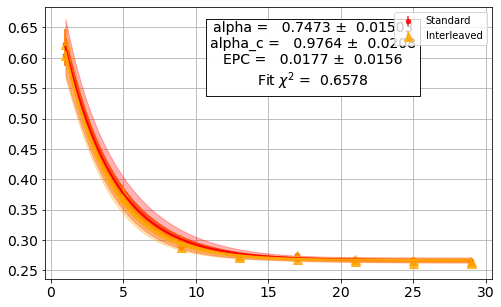

DbAnalysisResultV1
- name: @Parameters_InterleavedRBAnalysis
- value: [0.46966437871995037, 0.7472862488978732, 0.9764044099017607, 0.26678096164648324]
- χ²: 0.6577579775754847
- quality: good
- extra: <4 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: alpha
- value: 0.747+/-0.015
- χ²: 0.6577579775754847
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: alpha_c
- value: 0.976+/-0.021
- χ²: 0.6577579775754847
- quality: good
- extra: <1 items>
- device_components: ['Q1', 'Q2']
- verified: False
DbAnalysisResultV1
- name: EPC
- value: 0.018+/-0.016
- χ²: 0.6577579775754847
- quality: good
- extra: <3 items>
- device_components: ['Q1', 'Q2']
- verified: False


In [7]:
lengths = np.arange(1, 30, 4)
num_samples = 10
seed = 1010
qubits = [1,2]
date= datetime.today()
CXerror=backend.properties().gate_error('cx',(1,2))
print(backend)
print('belem_q1,2')
print(f"reported CXerror at {date} is {CXerror}")
print(datetime.today())

duration=backend.properties().gate_length('cx',(1,2))/backend.configuration().dt
delay_qc = QuantumCircuit(2)
delay_qc.delay(round(duration), [0], unit="dt")
delay_qc.delay(round(duration), [1], unit="dt")
int_exp2 = InterleavedRB(
    interleaved_element=delay_qc, qubits=[1,2], lengths=lengths, num_samples=num_samples, seed=seed)
int_exp2.set_transpile_options(scheduling_method='asap')
# Run
int_expdata2 = int_exp2.run(backend, shots=1000).block_for_results()
int_results2 = int_expdata2.analysis_results()
# View result data
display(int_expdata2.figure(0))
for result in int_results2:
    print(result)

# Coherence limited error

In [4]:
date= datetime.today()
qubit='belem_q12'
belem_q12=RBUtils.coherence_limit_error(2, 
backend.properties().gate_length('cx',(1,2)),
 t1s=[backend.properties().t1(1),backend.properties().t1(2)], 
 t2s=[backend.properties().t1(1),backend.properties().t1(2)])
print(f'{qubit} CLE is {belem_q12} on {date}')

belem_q12 CLE is 0.006137728797481934 on 2022-05-29 20:19:38.603234


### CLE(0.006)<2qDelay(0.01)<CX(0.11)